In [26]:
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import DataFrame, Series
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'Raw_debates')
RESULT_DIR = os.path.join(ROOT_DIR, 'candidate_lines')

candidates = {'CLINTON', 'SANDERS', 'TRUMP', 'RUBIO', 'CRUZ'}
cand_list = sorted(candidates)

stops = set(stopwords.words("english"))

%matplotlib inline

In [27]:
# parameters

numWords = 1500
minLength = 200

In [28]:
word_dic = {'action': 'act',
               'agreement': 'agree',
               'americans': 'american',
               'asked': 'ask',
               'asking': 'ask',
               'going': 'go',
               'states': 'state',
               'working': 'work',
               'millions': 'million',
               'bringing': 'bring',
               'businesses': 'business',
               'candidates': 'candidate',
               'children': 'child',
               'comes': 'come',
               'coming': 'come',
               'companies': 'company',
               'countries': 'country',
               'deals': 'deal',
               'economic': 'economy',
               'families': 'family',
               'fighting': 'fight',
               'gets': 'get',
               'getting': 'get',
               'goes': 'go',
               'got': 'get',
               'groups': 'group',
               'guns': 'gun',
               'happened': 'happen',
               'happening': 'happen',
               'helped': 'help',
               'issues': 'issue',
               'knows': 'know',
               'laws': 'law',
               'lives': 'live',
               'living': 'live',
               'making': 'make',
               'needs': 'need',
               'passed': 'pass',
               'problems': 'problem',
               'putting': 'put',
               'really': 'real',
               'republicans': 'republican',
               'running': 'run',
               'saying': 'say',
               'said': 'say',
               'seeing': 'see',
               'seen': 'see',
               'started': 'start',
               'supported': 'support',
               'taking': 'take',
               'talked': 'talk',
               'talking': 'talk',
               'terrorists': 'terrorist',
               'terrorism': 'terrorist',
               'things': 'thing',
               'trying': 'try',
               'used': 'use',
               'using': 'use',
               'voted': 'vote',
               'wages': 'wage',
               'wanted': 'want',
               'wants': 'want',
               'building': 'build',
               'called': 'call',
               'came': 'come',
               'communities': 'community',
               'costs': 'cost',
               'deffence': 'deffend',
               'difference': 'different',
               'drugs': 'drug',
               'gave': 'give',
               'given': 'give',
               'gone': 'go',
               'higher': 'high',
               'highest': 'high',
               'interests': 'interest',
               'jobs': 'job',
               'longer': 'long',
               'looked': 'look',
               'looking': 'look',
               'lost': 'lose',
               'made': 'make',
               'means': 'mean',
               'paying': 'pay',
               'planned': 'plan',
               'programs': 'program',
               'raising': 'raise',
               'reasons': 'reason',
               'ringing': 'ring',
               'says': 'say',
               'saw': 'see',
               'wealthy': 'wealth',
               'worked': 'work',
               'years': 'year'}

In [29]:
def get_raw_text(cand_name):
    file_name = '{0}.txt'.format(cand_name)
    file_path = os.path.join(RESULT_DIR, file_name)
    with open(file_path, 'rb') as f:
        return f.read()

def raw_to_blocks(cand_name, raw_text, delimiter='\r\n\r\n', min_len=minLength):
    # Delete candidate's name
    names_removed = raw_text.replace(cand_name + ':', '')
    
    # Split the text into paragraphs
    splitted = names_removed.split(delimiter)

    # Gather only long enough paragraphs
    rets = [paragraph for paragraph in splitted if len(paragraph) > min_len]
    return rets

# Replace words that are virtually same into one word. 
def hard_code_process(text):
    separate_word = ' {0} '
    text = separate_word.format(text)
    
    for key, value in word_dic.iteritems():
        key = separate_word.format(key)
        value = separate_word.format(value)
        text = text.replace(key, value)
    return text

def process_paragraph(paragraph):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paragraph) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    rets = ' '.join(meaningful_words)
    return hard_code_process(rets)

def get_processed_lines(cand_name, delimiter='\r\n\r\n', min_len=minLength):
    raw_text = get_raw_text(cand_name)
    blocks = raw_to_blocks(cand_name, raw_text, 
                           delimiter=delimiter, min_len=min_len)
    return map(process_paragraph, blocks)

def get_vectorizer(cand_lines, max_features=1000):
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = max_features)
    
    concatenated = []
    for cand_name, lines in cand_lines.iteritems():
        concatenated += lines
    
    vectorizer.fit(concatenated)
    return vectorizer

In [30]:
# Examples
cand_lines = {c: get_processed_lines(c) for c in candidates}
vectorizer = get_vectorizer(cand_lines, numWords)

vocab = vectorizer.get_feature_names()
clinton_train = vectorizer.transform(cand_lines['CLINTON']).toarray()

In [38]:
# Split training data and test data
def test_train_split(cand_lines, test_ratio=0.25):
    cands = cand_lines.keys()
    test_data = dict.fromkeys(cands)
    train_data = dict.fromkeys(cands)
    for c in cands:
        lines = cand_lines[c]
        l = len(lines)
        test_len = int(l * test_ratio)
        test_indices = set(np.random.choice(l, test_len, replace=False))
        train_indices = set(range(l)) - test_indices
        test_data[c] = list(np.take(lines, list(test_indices)))
        train_data[c] = list(np.take(lines, list(train_indices)))
    return test_data, train_data

def normalize(data):
    rets = dict()
    for c in data:
        d = data[c].astype(float)
        _sum = d.sum(axis=1)
        _sum[_sum==0] = 1
#         rets[c] = (d.T).T
        rets[c] = (d.T / _sum).T
    return rets

def normalizeBinary(data):
    rets = dict()
    for c in data:
        d = data[c].astype(float)
        d[d!=0] = 1
       
        rets[c] = d
    return rets

In [39]:
# Process the data

cand_lines = {c: get_processed_lines(c) for c in candidates}
test_data, train_data = test_train_split(cand_lines, 0.25)

vectorizer = get_vectorizer(train_data, numWords)

for c in train_data:
    train_data[c] = vectorizer.transform(train_data[c]).toarray()
    test_data[c] = vectorizer.transform(test_data[c]).toarray()
    
# Processing proportional data

train_data = normalize(train_data)
test_data = normalize(test_data)

train_x, test_x = None, None
train_y, test_y = [], []

for c in train_data:
    i  = cand_list.index(c)
    if train_x is None:
        train_x = train_data[c]
    else:
        train_x = np.concatenate((train_x, train_data[c]))
    train_y += [i] * len(train_data[c])
    
for c in test_data:
    i  = cand_list.index(c)
    if test_x is None:
        test_x = test_data[c]
    else:
        test_x = np.concatenate((test_x, test_data[c]))
    test_y += [i] * len(test_data[c])
    
# Processing binary data

train_dataBin = normalizeBinary(train_data)
test_dataBin = normalizeBinary(test_data)

train_xBin, test_xBin = None, None
train_yBin, test_yBin = [], []

for c in train_dataBin:
    i  = cand_list.index(c)
    if train_xBin is None:
        train_xBin = train_dataBin[c]
    else:
        train_xBin = np.concatenate((train_xBin, train_dataBin[c]))
    train_yBin += [i] * len(train_dataBin[c])
    
for c in test_dataBin:
    i  = cand_list.index(c)
    if test_xBin is None:
        test_xBin = test_dataBin[c]
    else:
        test_xBin = np.concatenate((test_xBin, test_dataBin[c]))
    test_yBin += [i] * len(test_dataBin[c])

In [33]:
set(train_y)

{0, 1, 2, 3, 4}

In [34]:
counts = []
for i in xrange(len(train_x[0,:])):
    counts.append(sum(train_xBin[:,i]) + sum(test_xBin[:,i]))

print(sorted(counts))

[1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,

In [42]:
_nTree = []
_depth = []
_train = []
_test = []
_timeTaken = []

_trainBin = []
_testBin = []
_timeTakenBin = []

tryNTree = [100,500,2000]
tryDepth = [50,100,500,1000]

for nTree in tryNTree:
    for depth in tryDepth:
        
        print('nTree: {0}, depth: {1}'.format(nTree,depth))
        
        start = time.time()
        tempRF = RandomForestClassifier(n_estimators=nTree, max_depth=depth)
        tempRF.fit(train_x, train_y)
        finish = time.time() - start
        print(finish)
        
        _timeTaken.append(finish)
        _nTree.append(nTree)
        _depth.append(depth)
        _train.append(tempRF.score(train_x, train_y))
        _test.append(tempRF.score(test_x, test_y))
        
        start = time.time()
        tempRF = RandomForestClassifier(n_estimators=nTree, max_depth=depth)
        tempRF.fit(train_xBin, train_yBin)
        finish = time.time() - start
        print(finish)
        
        _timeTakenBin.append(finish)
        _trainBin.append(tempRF.score(train_xBin, train_yBin))
        _testBin.append(tempRF.score(test_xBin, test_yBin))
        

nTree: 100, depth: 50
1.35199999809
1.09899997711
nTree: 100, depth: 100
1.27400016785
1.15799999237
nTree: 100, depth: 500
1.32299995422
1.14400005341
nTree: 100, depth: 1000
1.27399992943
1.16900014877
nTree: 500, depth: 50
5.86000013351
5.33100008965
nTree: 500, depth: 100
6.25999999046
5.98699998856
nTree: 500, depth: 500
6.42299985886
5.82099986076
nTree: 500, depth: 1000
6.72000002861
5.86899995804
nTree: 2000, depth: 50
23.9099998474
21.8280000687
nTree: 2000, depth: 100
26.3050000668
23.6879999638
nTree: 2000, depth: 500
25.5720000267
23.5269999504
nTree: 2000, depth: 1000
25.6620001793
24.236000061


In [43]:
DataFrame({'nTree': _nTree, 'depth': _depth, 'train_score': _train, 'test_score': _test,'train_scoreBin': _trainBin, 'test_scoreBin': _testBin, 'time taken': _timeTaken})

,depth,nTree,test_score,test_scoreBin,time taken,train_score,train_scoreBin
0,50,100,0.658252,0.654369,1.352,1,1
1,100,100,0.666019,0.662136,1.274,1,1
2,500,100,0.669903,0.656311,1.323,1,1
3,1000,100,0.666019,0.685437,1.274,1,1
4,50,500,0.666019,0.679612,5.860,1,1
5,100,500,0.667961,0.677670,6.260,1,1
6,500,500,0.662136,0.687379,6.423,1,1
7,1000,500,0.679612,0.681553,6.720,1,1
8,50,2000,0.664078,0.685437,23.910,1,1
9,100,2000,0.669903,0.685437,26.305,1,1


In [15]:
confusion_matrix(test_y,tempRF.predict(test_xBin))

array([[70,  5,  8, 15, 11],
       [ 4, 65, 11,  2, 16],
       [ 7, 12, 77,  3,  9],
       [ 8,  1, 13, 58, 18],
       [ 4,  5,  3,  4, 86]])

In [25]:
# result = tempRF.predict_proba(np.eye(1500))
np.unique(test_y, return_counts = True)


(array([0, 1, 2, 3, 4]), array([109,  98, 108,  98, 102], dtype=int64))

In [18]:
DataFrame(result)

,0,1,2,3,4
0,0.0185,0.2895,0.5735,0.0210,0.0975
1,0.0410,0.2975,0.5405,0.0205,0.1005
2,0.0275,0.2590,0.5730,0.0345,0.1060
3,0.0180,0.2835,0.5525,0.0195,0.1265
4,0.0190,0.2980,0.5650,0.0205,0.0975
5,0.0535,0.2805,0.5315,0.0230,0.1115
6,0.0190,0.2940,0.5575,0.0205,0.1090
7,0.0240,0.2775,0.5465,0.0575,0.0945
8,0.0190,0.2875,0.5565,0.0395,0.0975
9,0.0190,0.2945,0.5675,0.0215,0.0975


In [59]:
result = Series(result)
result.describe()

for i in range(5):
    print i, (result==i).sum()
    

0 4
1 32
2 1454
3 4
4 6


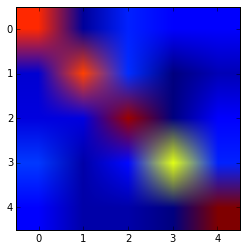

In [52]:
plt.imshow(confusion_matrix(test_y,tempRF.predict(test_xBin)))

In [45]:
cand_list

['CLINTON', 'CRUZ', 'RUBIO', 'SANDERS', 'TRUMP']

In [15]:
# Optimize C and gamma

_C = []
_gamma = []
_train = []
_test = []

for C in [0.01, 0.1, 1, 10, 100]:
    for gamma in [0.01, 0.1, 1, 10, 100]:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(train_x, train_y)
        _C.append(C)
        _gamma.append(gamma)
        _train.append(clf.score(train_x, train_y))
        _test.append(clf.score(test_x, test_y))

In [16]:
DataFrame({'C': _C, 'gamma': _gamma, 'train_score': _train, 'test_score': _test})

,C,gamma,test_score,train_score
0,0.01,0.01,0.211650,0.210560
1,0.01,0.10,0.211650,0.210560
2,0.01,1.00,0.211650,0.210560
3,0.01,10.00,0.211650,0.210560
4,0.01,100.00,0.211650,0.210560
5,0.10,0.01,0.211650,0.210560
6,0.10,0.10,0.211650,0.210560
7,0.10,1.00,0.211650,0.210560
8,0.10,10.00,0.322330,0.364456
9,0.10,100.00,0.211650,0.210560
